In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import ttest_ind, pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# ------------------------
# 1. Load your data
# ------------------------
# Your protein data: rows = samples, columns = protein IDs, plus metadata columns
# Example: data.csv contains columns: ['SampleID', 'Age', 'Cohort', protein1, protein2, ...]
data = pd.read_csv("../data/processed/ProteinsForAgingPredictionModel.csv")
data

sample_id  Age    Cohort    IGKV3-7   IGLV4-69   IGLV8-61   IGLV4-60  \
0            1   39     Acute   8.523733   9.636996   9.690880   8.730609   
1           10   62     Acute   8.530517  11.595760  10.647752  10.127333   
2           98   74     Acute   7.438673  10.683301  10.356419   8.703383   
3          101   39      PASC   8.265203  11.945851  12.656924  10.606516   
4          102   20      PASC   9.124052  11.070182  13.799554  11.532909   
..         ...  ...       ...        ...        ...        ...        ...   
325        385   83  Acute_NC   7.633878  11.671451  10.601080  13.477529   
326        386   75  Acute_NC   9.219379  12.438398  13.307580  10.490713   
327        387   50  Acute_NC   8.907882  12.994328  10.507375   7.877574   
328        388   53  Acute_NC   7.593598   9.093530  12.936225   8.987761   
329        389   49  Acute_NC  10.505263  11.989147   9.240142  10.264162   

      IGLV7-46   IGLV2-18   IGLV3-10  ...      NUMBL    MAP3K4      FCGBP  \
0     9.120743   9.079575   9.211454  ...   9.128869  8.258930   7.490772   
1    13.406860   9.276704  11.947706  ...   9.213440  8.499768  10.951934   
2     8.599505   8.717123  10.497793  ...   8.767657  7.997835  10.128839   
3     9.439244   9.971044  11.843203  ...   9.486455  7.171827  11.416690   
4    12.791586  11.758852  12.785557  ...   9.467924  7.278964   7.978523   
..         ...        ...        ...  ...        ...       ...        ...   
325   9.498152   9.974980  11.059275  ...  10.161397  7.943243   8.214143   
326   9.953727  12.376123  11.959869  ...  10.700743  7.166952   8.725276   
327   8.123693  11.852071  11.231883  ...   9.913293  8.361388   7.085185   
328   8.594911   7.443560  12.016812  ...  11.169720  8.329748   3.208834   
329   9.771554  13.301061  13.190115  ...   9.572447  7.246797   7.520819   

         CAPN7      WASF2      ENPP4  IVNS1ABP    SEC23IP       LY96  \
0     9.590950  13.135866   9.535921  7.708783   9.711688   7.940595   
1     9.350553  13.298367   9.775311  7.243021   9.620704   7.600204   
2    10.297829  12.347135  10.954949  7.870191  10.542883   5.725974   
3    10.438761  13.553229   9.746592  6.990025   9.924173   7.467163   
4     9.840045  12.491502   9.879116  7.398396   9.810549   9.344618   
..         ...        ...        ...       ...        ...        ...   
325  11.256751  12.908372   8.542101  6.794798   7.973783  10.552140   
326  11.019943  13.850772   7.220786  7.125543   9.214003   9.341212   
327  10.488805  13.326599   9.415069  7.116600   9.815182   8.185411   
328  11.373005  13.801980   8.913413  7.708040   9.531886   7.899251   
329  10.480648  13.242215   9.361344  6.430557   9.558430   9.394124   

       COLEC10  
0    14.980541  
1    13.640022  
2    13.222261  
3    16.062222  
4    16.152539  
..         ...  
325  16.722824  
326  17.327335  
327  16.279836  
328  13.226909  
329  16.957033  

[330 rows x 6975 columns]

In [6]:
# Load model coefficients: two columns ['Protein', 'Coefficient']
coeffs = pd.read_csv("../data/processed/Lehallier2019_ModelCoefficients_fixed.csv")

# Ensure intercept is stored (if available)
intercept = coeffs.loc[coeffs['Variable'] == '(Intercept)', 'Coefficients'].values[0]
coeffs = coeffs[coeffs['Variable'] != '(Intercept)']

coeffs

Variable  Coefficients
1     SCARF2      2.259681
2     ARFIP2      1.734075
3       SOST      1.685101
4        PTN      1.640670
5      WFDC2      1.354360
..       ...           ...
369    CXCL1      0.000444
370     IDO1      0.000209
371  CREB3L4      0.000181
372  SCGB1C1      0.000105
373   IL18BP      0.000094

[373 rows x 2 columns]

In [7]:
# ------------------------
# 2. Match proteins between model and your dataset
# ------------------------
model_proteins = coeffs['Variable'].tolist()
available_proteins = [p for p in model_proteins if p in data.columns]

print(f"Model uses {len(model_proteins)} proteins, found {len(available_proteins)} in your data")

# Subset data and coefficients to matched proteins
coeffs = coeffs[coeffs['Variable'].isin(available_proteins)]
X = data[available_proteins]

Model uses 373 proteins, found 190 in your data


In [9]:
# ------------------------
# 3. Apply the model
# ------------------------
# Compute predicted age
beta = coeffs.set_index('Variable')['Coefficients']
pred_age = intercept + np.dot(X, beta)

data['Predicted_Age'] = pred_age

# ------------------------
# 4. Model performance
# ------------------------
true_age = data['Age']
mae = mean_absolute_error(true_age, pred_age)
r2 = r2_score(true_age, pred_age)
corr, p_corr = pearsonr(true_age, pred_age)

print(f"Model Performance:\n MAE: {mae:.2f}\n R²: {r2:.3f}\n Pearson r: {corr:.3f} (p={p_corr:.2e})")

Model Performance:
 MAE: 29.84
 R²: -3.487
 Pearson r: 0.558 (p=1.93e-28)


More than two cohorts detected; consider ANOVA or linear model.


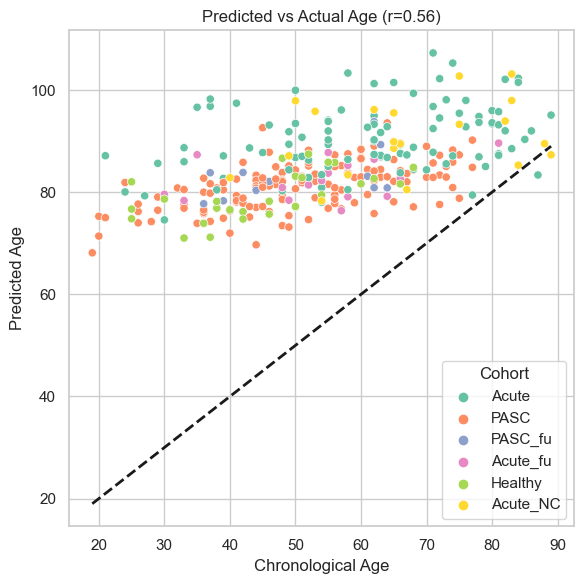

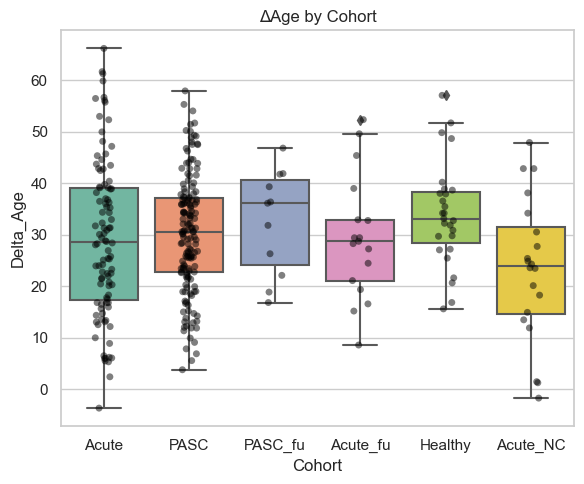

In [10]:
# ------------------------
# 5. Compute ΔAge
# ------------------------
data['Delta_Age'] = data['Predicted_Age'] - data['Age']

# ------------------------
# 6. Compare cohorts
# ------------------------
# Assuming Cohort column has two groups: 'Group1', 'Group2'
cohort_groups = data['Cohort'].unique()
if len(cohort_groups) == 2:
    group1 = data.loc[data['Cohort'] == cohort_groups[0], 'Delta_Age']
    group2 = data.loc[data['Cohort'] == cohort_groups[1], 'Delta_Age']
    t_stat, p_val = ttest_ind(group1, group2, equal_var=False)
    print(f"\nΔAge difference between cohorts:\n t={t_stat:.3f}, p={p_val:.3e}")
else:
    print("More than two cohorts detected; consider ANOVA or linear model.")

# ------------------------
# 7. Plots
# ------------------------
sns.set(style="whitegrid")

# Predicted vs Actual Age
plt.figure(figsize=(6,6))
sns.scatterplot(x=true_age, y=data['Predicted_Age'], hue=data['Cohort'], palette="Set2")
plt.plot([true_age.min(), true_age.max()], [true_age.min(), true_age.max()], 'k--', lw=2)
plt.xlabel("Chronological Age")
plt.ylabel("Predicted Age")
plt.title(f"Predicted vs Actual Age (r={corr:.2f})")
plt.tight_layout()
plt.show()

# ΔAge by Cohort
plt.figure(figsize=(6,5))
sns.boxplot(x='Cohort', y='Delta_Age', data=data, palette="Set2")
sns.stripplot(x='Cohort', y='Delta_Age', data=data, color='black', alpha=0.5)
plt.title("ΔAge by Cohort")
plt.tight_layout()
plt.show()